We want to now demonstrate how the Aurora moves using ewograms!

In [14]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp
import scienceplots

plt.style.use(['science','no-latex'])
alt=150

In [15]:
time_array=(datetime(2022,12,19,14,2), datetime(2022,12,19,14,8))

Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing 

Lets define the imager

In [16]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt,   time_range=time_array, colors='r')


Now lets look at images and define some lines for ewograms

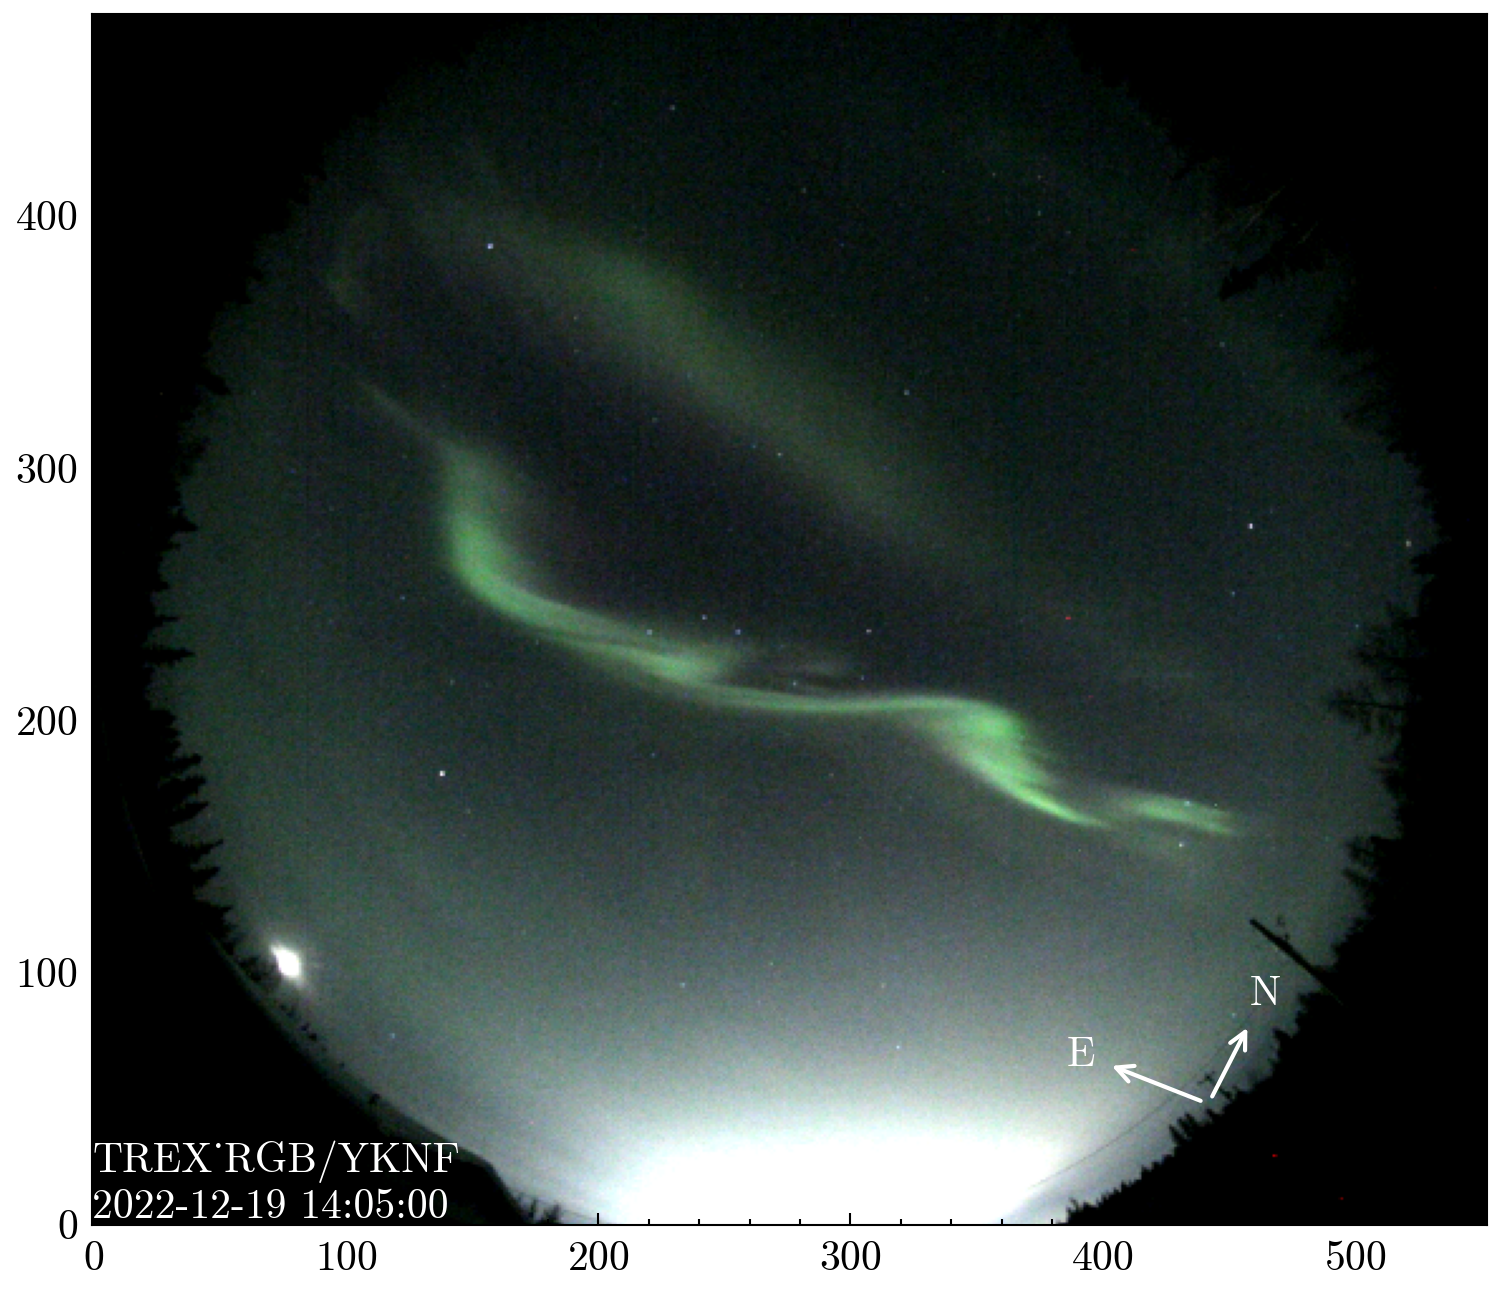

In [17]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
from datetime import datetime
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=alt,  time=datetime(2022,12,19,14,5), colors='rgb')

ax, im_good = asi_single.plot_fisheye(ax=ax)


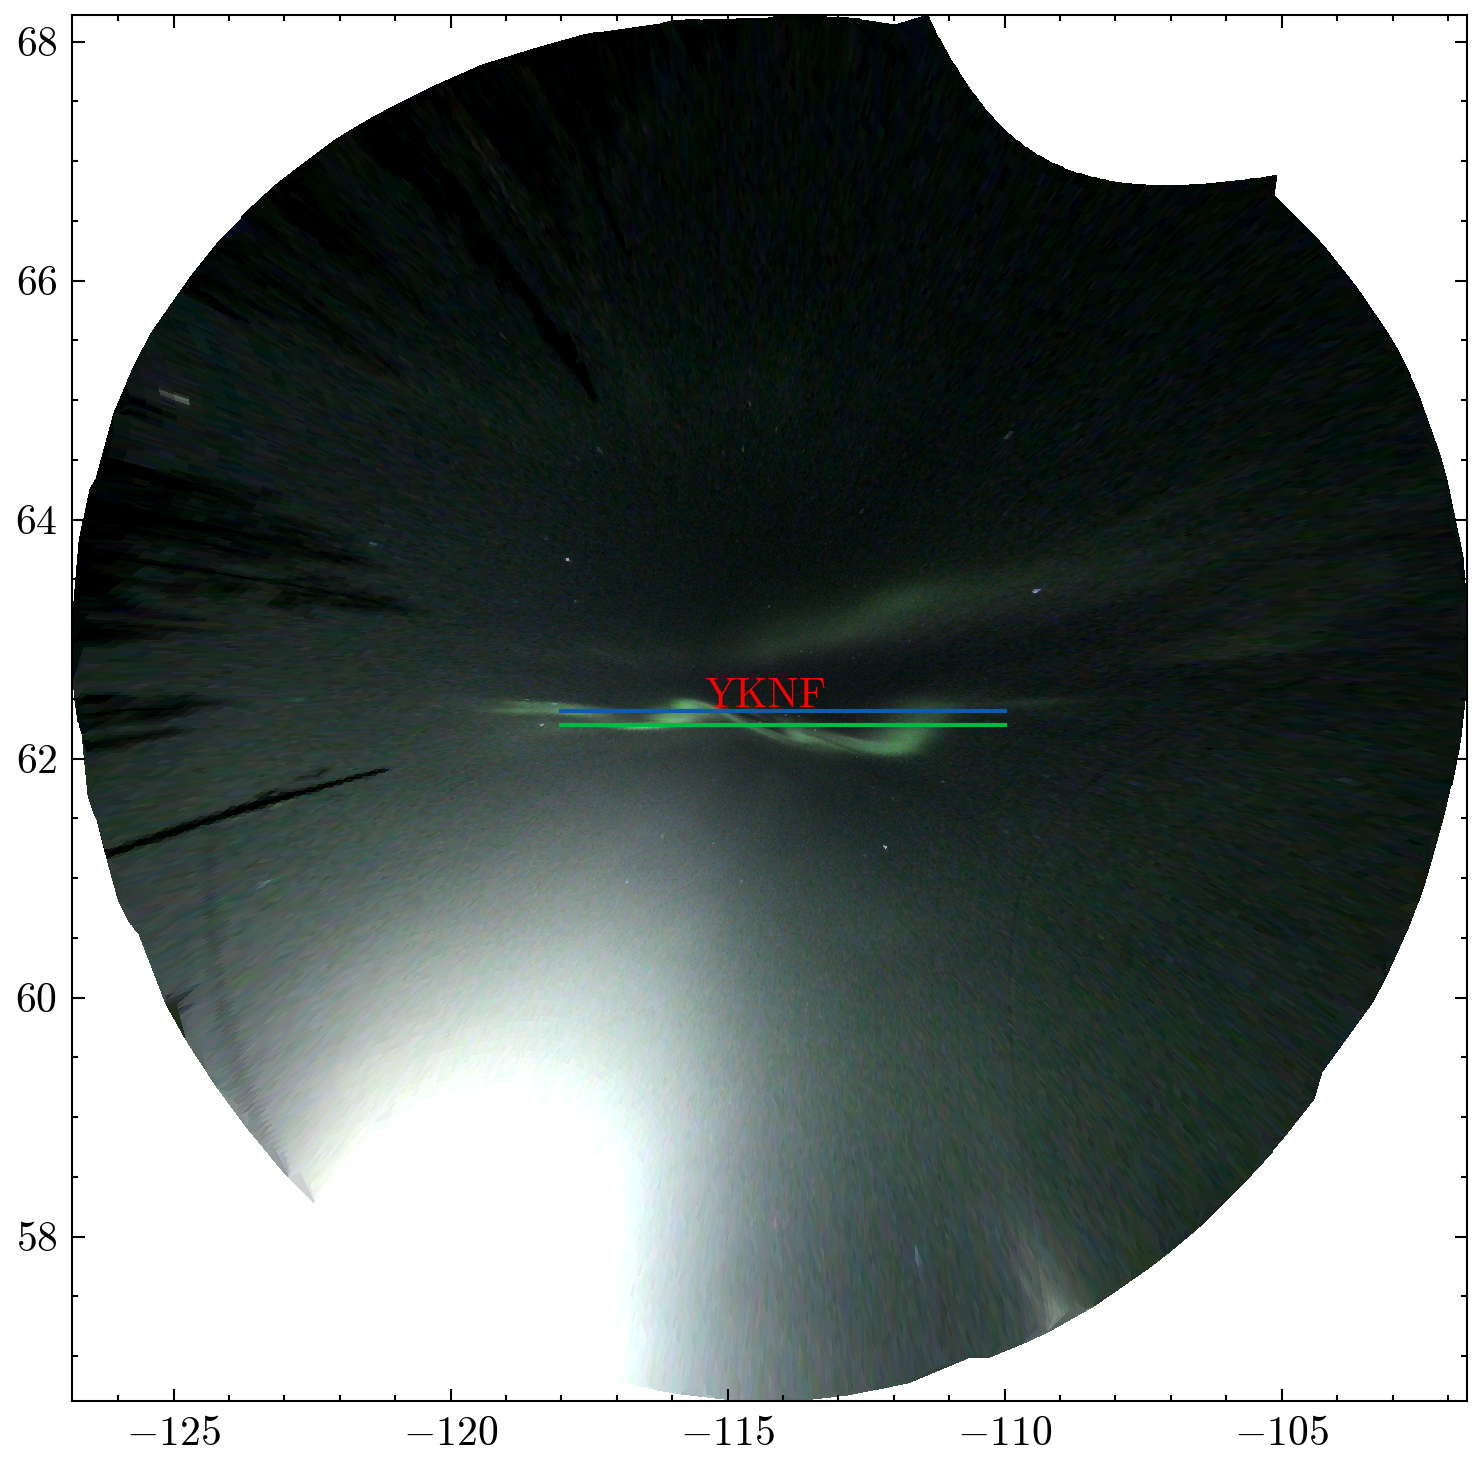

In [18]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax, im_good = asi_single.plot_map(ax=ax)
coords=im_good.get_coordinates()
x_coords=coords[:,:,0]
y_coords=coords[:,:,1]
x = np.linspace(-118, -110, 200)
y= np.linspace(62.4, 62.4, 200)
plt.plot(x,y)
y= np.linspace(62.28, 62.28, 200)
plt.plot(x,y)




In [19]:


# grid_lats, grid_lons: 2D arrays representing the latitude and longitude grid
# line_lats, line_lons: 1D arrays representing the latitude and longitude of the line

def find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons):
    # Reshape line_lats and line_lons for broadcasting with the grid
    line_lats_reshaped = line_lats[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)
    line_lons_reshaped = line_lons[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)

    # Compute squared Euclidean distances using broadcasting
    lat_diff = grid_lats[np.newaxis, :, :] - line_lats_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    lon_diff = grid_lons[np.newaxis, :, :] - line_lons_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    distances = lat_diff**2 + lon_diff**2  # Shape: (num_points, grid_lat_dim, grid_lon_dim)

    # Find the flat index of the minimum distance for each point along the grid axes
    min_indices_flat = np.argmin(distances.reshape(distances.shape[0], -1), axis=1)  # Shape: (num_points,)

    # Convert flat indices back to 2D grid indices for all points at once
    grid_shape = grid_lats.shape
    closest_indices = np.stack(np.unravel_index(min_indices_flat, grid_shape), axis=1)

    return closest_indices.T

# Example usage
grid_lats = np.array(y_coords)  # Replace y_coords with the actual grid latitude array (2D)
grid_lons = np.array(x_coords)  # Replace x_coords with the actual grid longitude array (2D)

line_lats = np.array(y)         # Replace y with the actual line latitude array (1D)
line_lons = np.array(x)         # Replace x with the actual line longitude array (1D)

closest_indices = find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons)


In [20]:
import numpy as np
# Define the coordinates for y values
x_1 = np.linspace(-119, -107, 500)  # x-coordinates (longitude range)
y_values = np.array([62.15, 62.25, 62.35, 62.45])  # y-values for different lines (latitude)
y_target = np.tile(y_values[:, np.newaxis], (1, 500))  # 2D array of shape (4, 800)
print(time_array[0], time_array[-1])
# Initialize ASI object
asi = asilib.asi.trex_rgb(location_code='yknf', alt=alt ,  time_range=(time_array[0], time_array[-1]))

# Lists to hold results
pixel_closest_list = np.zeros((4, 120, 500, 3), dtype=np.uint8)
time_ewo = []

movie_generator = asi.animate_map_gen()
closest_indices = []
for i, (time, image, _, im) in enumerate(movie_generator):
    if i ==0:
        coords = im.get_coordinates()
        grid_lons = coords[:, :, 0]
        grid_lats = coords[:, :, 1]
        # Loop over each y-value target line
        for j in range(len(y_values)):
            # Get closest grid points for all 800 points on the line
            closest_indices.append(np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_target[j], x_1))) 
            
            # Ensure closest_indices has shape (800, 2) where 800 points correspond to x_1
            # closest_indices[0] = indices of closest grid points for latitudes
            # closest_indices[1] = indices of closest grid points for longitudes

            if closest_indices[j].shape[0] == 500:
                # Fetch the RGB values for all 800 closest grid points using advanced indexing
                pixel_values = image[closest_indices[j][:, 0], closest_indices[j][:, 1], :]  # shape (800, 3)
                
                # Append all pixel values for this y-value line
                pixel_closest_list[j][i] = pixel_values
            else:
                print(f"Error: closest_indices does not match the expected shape for y_value index {j}")
    else:
         for j in range(len(y_values)):
            # Get closest grid points for all 800 points on the line
            
            # Ensure closest_indices has shape (800, 2) where 800 points correspond to x_1
            # closest_indices[0] = indices of closest grid points for latitudes
            # closest_indices[1] = indices of closest grid points for longitudes

            if closest_indices[j].shape[0] == 500:
                # Fetch the RGB values for all 800 closest grid points using advanced indexing
                pixel_values = image[closest_indices[j][:, 0], closest_indices[j][:, 1], :]  # shape (800, 3)
                
                # Append all pixel values for this y-value line
                pixel_closest_list[j][i] = pixel_values
            else:
                print(f"Error: closest_indices does not match the expected shape for y_value index {j}")


    time_ewo.append(time)
    if i==119:
        break

# Unpack the pixel closest lists for each y-value
pixel_closest_30, pixel_closest_32, pixel_closest_34, pixel_closest_36 = pixel_closest_list


2022-12-19 14:02:00 2022-12-19 14:08:00



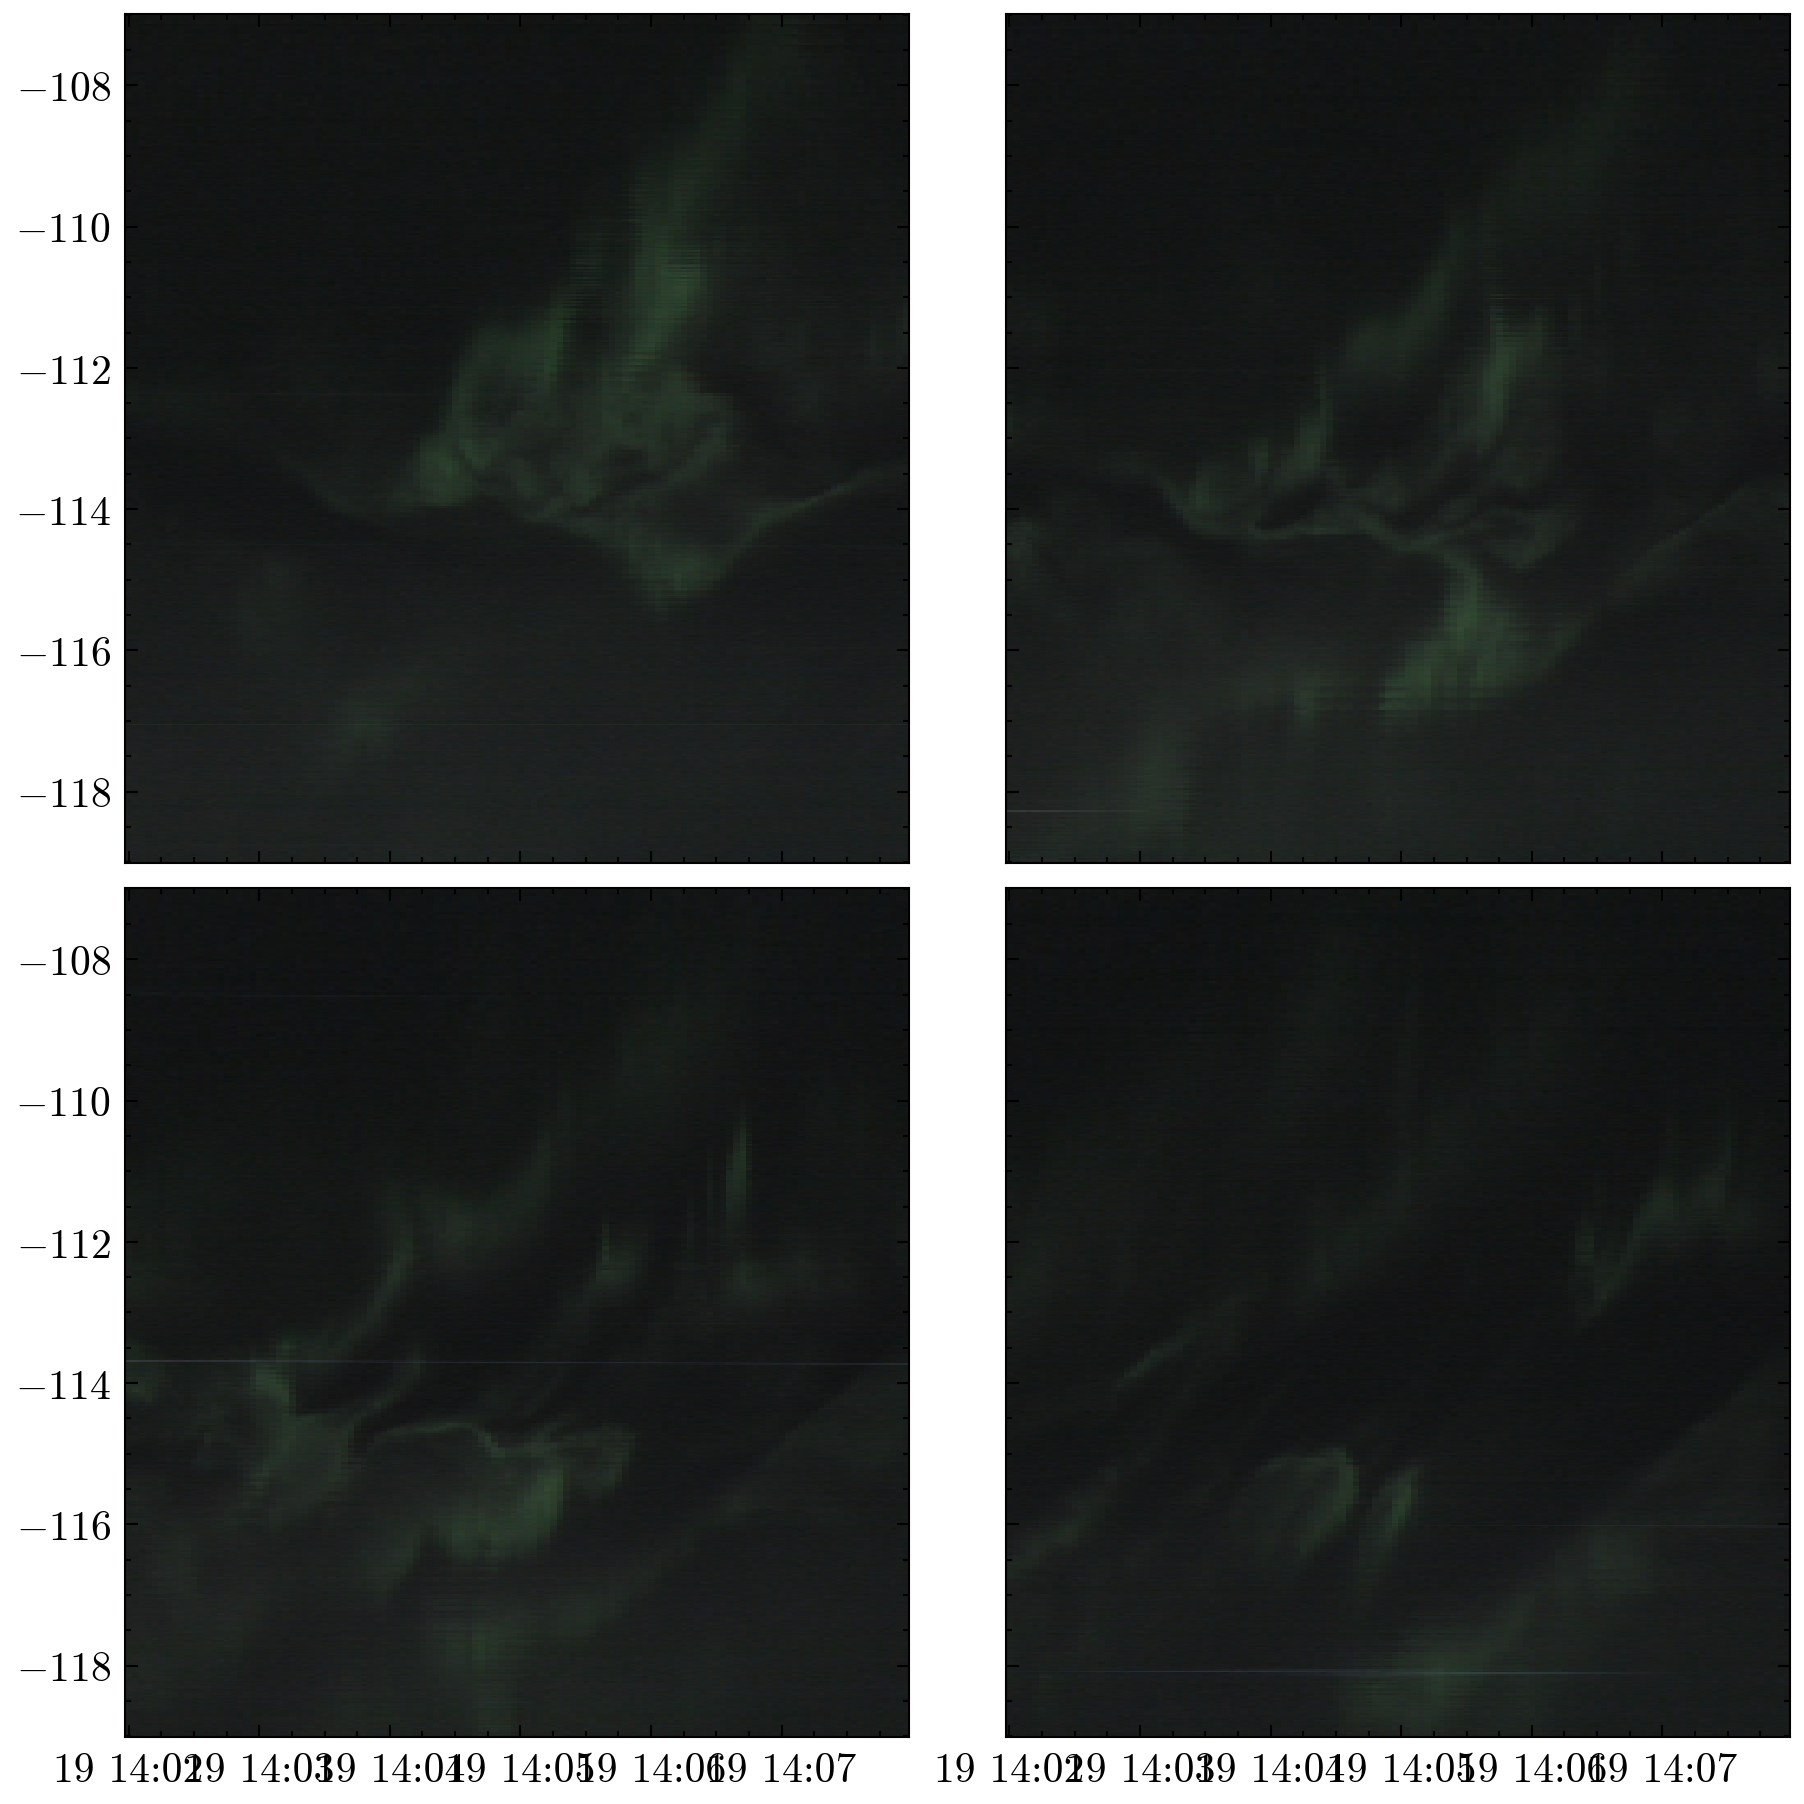

In [21]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300, nrows=2,ncols=2, constrained_layout=True, sharex=True, sharey=True)

ax[0][0].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_30, 1, 0 ))
ax[0][1].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_32, 1, 0 ))
ax[1][0].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_34, 1, 0 ))
ax[1][1].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_36, 1, 0 ))

Distance: 111.73 km
Time: 85.0 s
Velocity: 1.3144340918685702
Distance: 121.92 km
Time: 90.0 s
Velocity: 1.3546299217501254
Distance: 160.55 km
Time: 115.0 s
Velocity: 1.3961107420332426
Distance: 160.29 km
Time: 115.0 s
Velocity: 1.3937879339944073


(-118.0, -110.0)

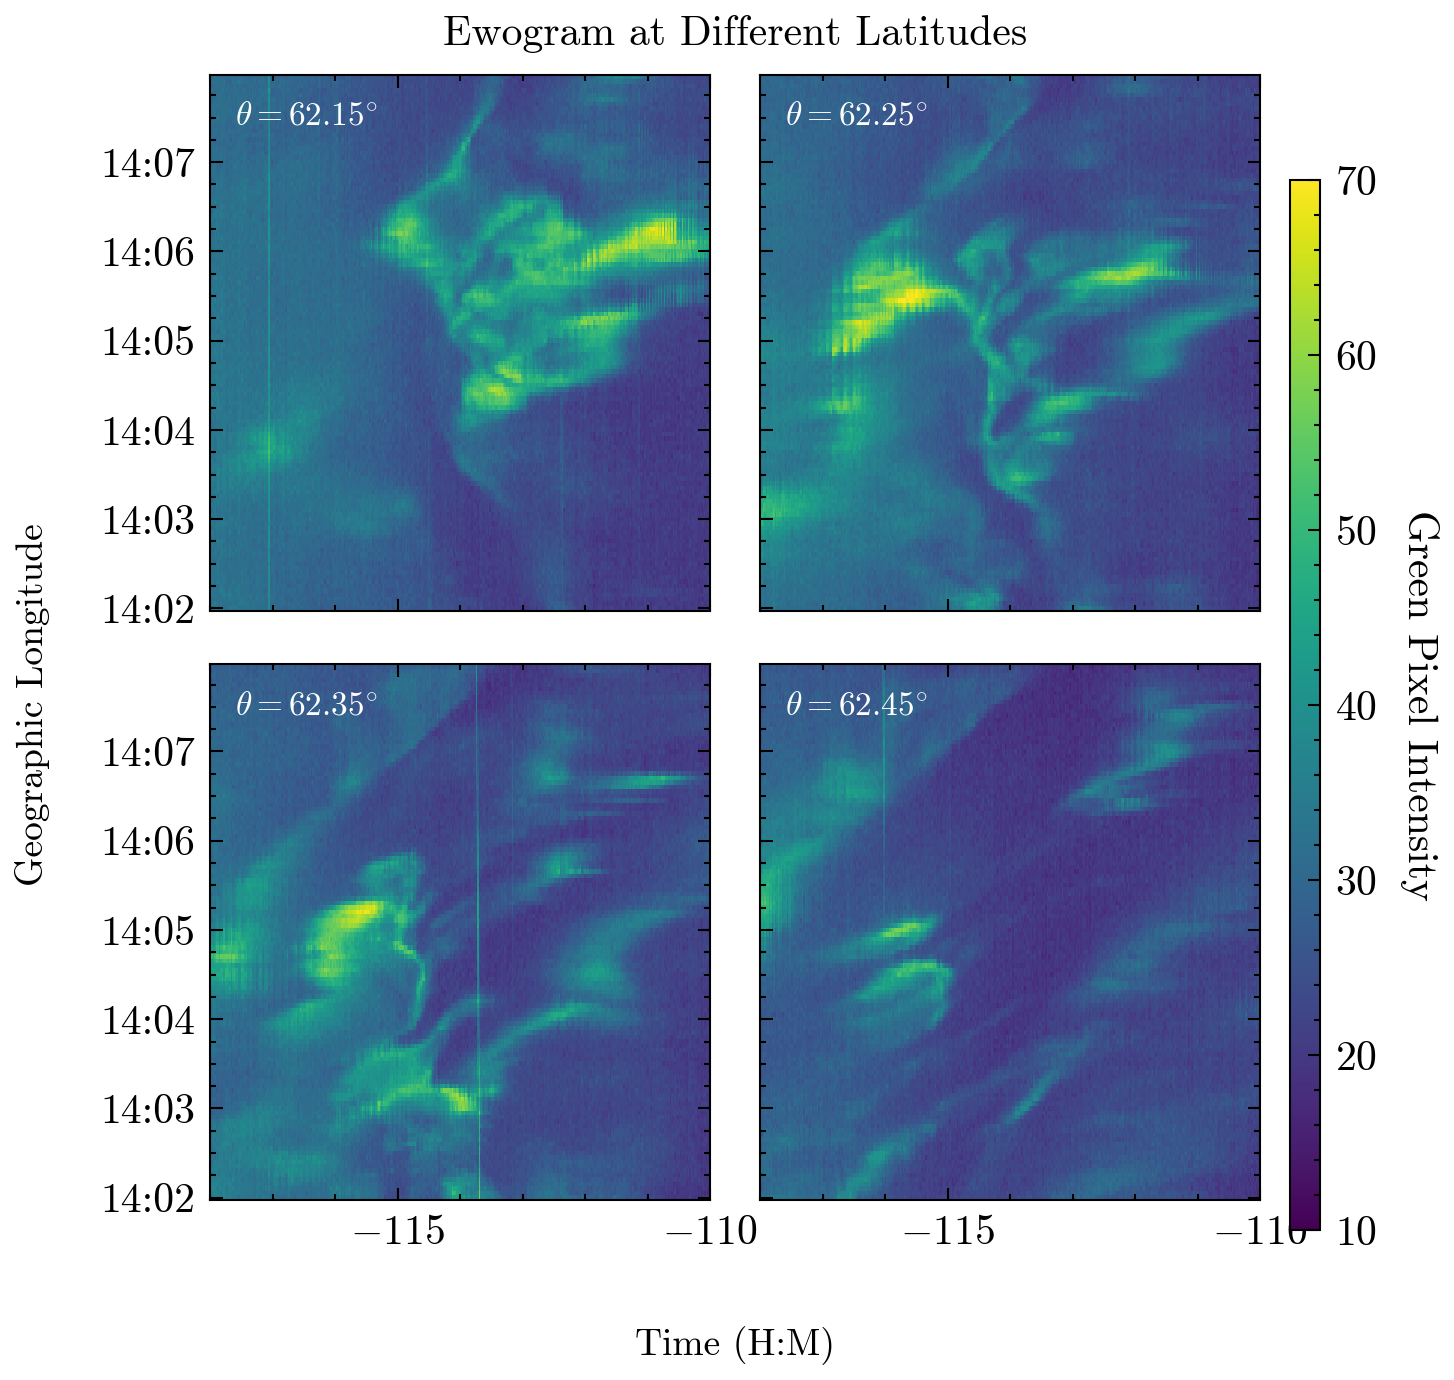

In [22]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from geopy.distance import geodesic

# Create the figure and subplots with further reduced white space
fig, ax = plt.subplots(figsize=(5,5), dpi=300, nrows=2, ncols=2, sharex=True, sharey=True)

# Plot the data
ax[0][0].pcolormesh(x_1,time_ewo, pixel_closest_30[:,:,1], vmin=10, vmax=70)
ax[0][1].pcolormesh(x_1,time_ewo, pixel_closest_32[:,:,1], vmin=10, vmax=70)
ax[1][0].pcolormesh(x_1,time_ewo, pixel_closest_34[:,:,1], vmin=10, vmax=70)
im = ax[1][1].pcolormesh( x_1,time_ewo, pixel_closest_36[:,:,1], vmin=10, vmax=70)

# Adjust subplot parameters to minimize white space even more
fig.subplots_adjust(left=0.15, right=0.85, top=0.92, bottom=0.17, hspace=0.1, wspace=0.1)

# Adjust colorbar positioning (narrower and closer to subplots)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Green Pixel Intensity', rotation=-90, labelpad=15 ) 
# Set x-axis formatters
locator = mdates.MinuteLocator(interval=1)  # Shows every minute
formatter = mdates.DateFormatter('%H:%M')

for axes in ax.flat:
    axes.yaxis.set_major_locator(locator)
    axes.yaxis.set_major_formatter(formatter)

# Set titles and labels
fig.suptitle("Ewogram at Different Latitudes", fontsize=10, y=0.96)  # Title closer to subplots
fig.supxlabel(r"Time (H:M)", fontsize=9, y=0.06)  # X label closer to bottom
fig.supylabel(r"Geographic Longitude", fontsize=9)  # Y label closer to left

# Add text labels to each subplot with minimal spacing
latitudes = [62.15, 62.25, 62.35, 62.45]
ax[0][0].text(0.05, 0.95, f"$\\theta={latitudes[0]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[0][0].transAxes, color='white', fontsize=8)
ax[0][1].text(0.05, 0.95, f"$\\theta={latitudes[1]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[0][1].transAxes, color='white', fontsize=8)
ax[1][0].text(0.05, 0.95, f"$\\theta={latitudes[2]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[1][0].transAxes, color='white', fontsize=8)
ax[1][1].text(0.05, 0.95, f"$\\theta={latitudes[3]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[1][1].transAxes, color='white', fontsize=8)

#ax1

start_datetime = pd.Timestamp('2022-12-19 14:06:05')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.25
end_longitude = -114.1
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

coord1 = (62.25, start_longitude)  
coord2 = (62.25, end_longitude )   

# Calculate the distance
distance = geodesic(coord1, coord2).kilometers




# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
#ax[0][0].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax2
start_datetime = pd.Timestamp('2022-12-19 14:06')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.6
end_longitude = -114.25
coord1 = (62.30, start_longitude)  
coord2 = (62.30, end_longitude )   

# Calculate the distance
distance = geodesic(coord1, coord2).kilometers
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
#ax[0][1].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax3
start_datetime = pd.Timestamp('2022-12-19 14:05:35')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -117.35
end_longitude = -114.25
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

coord1 = (62.35, start_longitude)  
coord2 = (62.35, end_longitude )  
distance = geodesic(coord1, coord2).kilometers
# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
#ax[1][0].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax4
start_datetime = pd.Timestamp('2022-12-19 14:05:35')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -117.5
end_longitude = -114.4
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)
coord1 = (62.40, start_longitude)  
coord2 = (62.40, end_longitude )   
distance = geodesic(coord1, coord2).kilometers
# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
#ax[1][1].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
ax[0][0].set_xlim(-118, -110)


In [23]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from geopy.distance import geodesic

# Create the figure and subplots with further reduced white space
fig, ax = plt.subplots(figsize=(5,5), dpi=300, nrows=2, ncols=2, sharex=True, sharey=True)

# Plot the data
ax[0][0].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_30, 1, 0 )[:,:,1], vmin=10, vmax=70)
ax[0][1].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_32, 1, 0 )[:,:,1], vmin=10, vmax=70)
ax[1][0].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_34, 1, 0 )[:,:,1], vmin=10, vmax=70)
im = ax[1][1].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_36, 1, 0 )[:,:,1], vmin=10, vmax=70)


# Adjust subplot parameters to minimize white space even more
fig.subplots_adjust(left=0.15, right=0.85, top=0.92, bottom=0.17, hspace=0.1, wspace=0.1)

# Adjust colorbar positioning (narrower and closer to subplots)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Green Pixel Intensity', rotation=-90, labelpad=15 ) 
# Set x-axis formatters
locator = mdates.MinuteLocator(interval=1)  # Shows every minute
formatter = mdates.DateFormatter('%H:%M')

for axes in ax.flat:
    axes.xaxis.set_major_locator(locator)
    axes.xaxis.set_major_formatter(formatter)
    axes.tick_params(axis='x', rotation=45)

# Set titles and labels
fig.suptitle("Ewogram at Different Latitudes", fontsize=10, y=0.96)  # Title closer to subplots
fig.supxlabel(r"Time (H:M)", fontsize=9, y=0.06)  # X label closer to bottom
fig.supylabel(r"Geographic Longitude", fontsize=9)  # Y label closer to left

# Add text labels to each subplot with minimal spacing
latitudes = [62.15, 62.25, 62.35, 62.45]
ax[0][0].text(0.05, 0.95, f"$\\theta={latitudes[0]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[0][0].transAxes, color='white', fontsize=8)
ax[0][1].text(0.05, 0.95, f"$\\theta={latitudes[1]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[0][1].transAxes, color='white', fontsize=8)
ax[1][0].text(0.05, 0.95, f"$\\theta={latitudes[2]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[1][0].transAxes, color='white', fontsize=8)
ax[1][1].text(0.05, 0.95, f"$\\theta={latitudes[3]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[1][1].transAxes, color='white', fontsize=8)

#ax1

start_datetime = pd.Timestamp('2022-12-19 14:06:05')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.25
end_longitude = -114.1
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

coord1 = (62.25, start_longitude)  
coord2 = (62.25, end_longitude )   

# Calculate the distance
distance = geodesic(coord1, coord2).kilometers




# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
#ax[0][0].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax2
start_datetime = pd.Timestamp('2022-12-19 14:06')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.6
end_longitude = -114.25
coord1 = (62.30, start_longitude)  
coord2 = (62.30, end_longitude )   

# Calculate the distance
distance = geodesic(coord1, coord2).kilometers
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax[0][1].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax3
start_datetime = pd.Timestamp('2022-12-19 14:05:35')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -117.4
end_longitude = -114.25
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

coord1 = (62.35, start_longitude)  
coord2 = (62.35, end_longitude )  
distance = geodesic(coord1, coord2).kilometers
# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax[1][0].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax4
start_datetime = pd.Timestamp('2022-12-19 14:05:35')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -117.5
end_longitude = -114.4
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)
coord1 = (62.40, start_longitude)  
coord2 = (62.40, end_longitude )   
distance = geodesic(coord1, coord2).kilometers
# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax[1][1].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")

axlist=ax.flatten()
times_of_spiral =  [datetime(2022,12,19,14,5,20), datetime(2022,12,19,14,5,10), datetime(2022,12,19,14,5,0), datetime(2022,12,19,14,4,45)]
for i in range(len(axlist)):
    axlist[i].tick_params(axis='both', colors='white', labelcolor='black', which='both')
print((111.1*0.15)/35)


#Invert time and longitude

#See if vaslov solutions from Rick create folds from velocity magnetic shear configurations, density ions, given magnetic shear and velocity shear coincident



Distance: 111.73 km
Time: 85.0 s
Velocity: 1.3144340918685702
Distance: 121.92 km
Time: 90.0 s
Velocity: 1.3546299217501254
Distance: 163.14 km
Time: 115.0 s
Velocity: 1.4186242414770807
Distance: 160.29 km
Time: 115.0 s
Velocity: 1.3937879339944073
0.47614285714285715


In [24]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300, tight_layout=True)

# Plot the data
ax.pcolormesh( x_1,time_ewo, pixel_closest_32[:,:,1], vmin=10, vmax=70)
start_datetime = pd.Timestamp('2022-12-19 14:06')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.6
end_longitude = -114.25

In [25]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300, tight_layout=True)

# Plot the data
ax.pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_32, 1, 0 )[:,:,1], vmin=10, vmax=70)
start_datetime = pd.Timestamp('2022-12-19 14:05:50')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.45
end_longitude = -113.95
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax.plot(date_range, longitude_values, color='white', linestyle='--', dashes=(5, 10))



In [26]:
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")

Distance: 160.29 km
Time: 100.0 s
Velocity: 1.6028561240935684
